# Reading a large file into pyspark

`pyspark` reads csv files line-by-line, so there is no need to use pandas or chunk the data.

#### Imports

In [17]:
from pyspark.sql import SparkSession
from more_pyspark import get_spark_types, to_pandas
from functoolz import pipeable
from dfply import *

spark = SparkSession.builder.appName('Ops').getOrCreate()

In [25]:
df = spark.read.csv("./data/uber/uber-trip-data/uber-raw-data-apr14.csv",
                   inferSchema=True,
                   header=True)
df

DataFrame[Date/Time: string, Lat: double, Lon: double, Base: string]

In [59]:
from pyspark.sql.functions import to_timestamp, col, dayofmonth, month, year, hour, dayofweek
from pyspark.sql.types import StringType
from more_pyspark import all_but
from calendar import day_name


df_new = (df
          .withColumn('date', to_timestamp(col('Date/Time'), format='M/d/yyyy H:mm:ss'))
          .withColumn('day', dayofmonth(col('date')))
          .withColumn('month', month(col('date')))
          .withColumn('year', year(col('date')))
          .withColumn('hour', hour(col('date')))
          .withColumn('weekday', dayofweek(col('date')))
          .drop('Date/Time')
         )
df_new.take(3)

[Row(Lat=40.769, Lon=-73.9549, Base='B02512', date=datetime.datetime(2014, 4, 1, 0, 11), day=1, month=4, year=2014, hour=0, weekday=3),
 Row(Lat=40.7267, Lon=-74.0345, Base='B02512', date=datetime.datetime(2014, 4, 1, 0, 17), day=1, month=4, year=2014, hour=0, weekday=3),
 Row(Lat=40.7316, Lon=-73.9873, Base='B02512', date=datetime.datetime(2014, 4, 1, 0, 21), day=1, month=4, year=2014, hour=0, weekday=3)]

In [67]:
cnts = (df_new
        .select('weekday')
        .groupBy('weekday')
        .agg(count('weekday').alias('cnt'))
        .collect() ) >> to_pandas
cnts = (cnts 
        >> mutate(day_name = X.weekday.apply(lambda n: day_name[n - 1])))

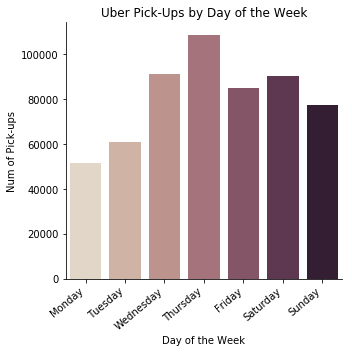

In [68]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="day_name", 
               y = 'cnt',
               kind="bar", 
               order=day_name,
               palette="ch:.25", 
               data=cnts
              )
     )

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 4 </font>

Create a `pyspark.sql` dataframe for the Uber pick-ups from May.  Compute and visualize the hourly frequencies for Uber pick-ups, this time with `pyspark` queries.

In [42]:
# Your code here

## <font color="blue"> Key </font>

In [70]:
df_may = spark.read.csv("./data/uber/uber-trip-data/uber-raw-data-may14.csv",
                   inferSchema=True,
                   header=True)
df_may

DataFrame[Date/Time: string, Lat: double, Lon: double, Base: string]

In [73]:
df_may_new = (df
              .withColumn('date', to_timestamp(col('Date/Time'), format='M/d/yyyy H:mm:ss'))
              .withColumn('hour', hour(col('date')))
              .drop('Date/Time')
         )
df_may_new.take(3)

[Row(Lat=40.7521, Lon=-73.9914, Base='B02512', date=datetime.datetime(2014, 5, 1, 0, 2), hour=0),
 Row(Lat=40.6965, Lon=-73.9715, Base='B02512', date=datetime.datetime(2014, 5, 1, 0, 6), hour=0),
 Row(Lat=40.7464, Lon=-73.9838, Base='B02512', date=datetime.datetime(2014, 5, 1, 0, 15), hour=0)]

In [74]:
cnts_may = (df_new
        .select('hour')
        .groupBy('hour')
        .agg(count('hour').alias('cnt'))
        .collect() ) >> to_pandas

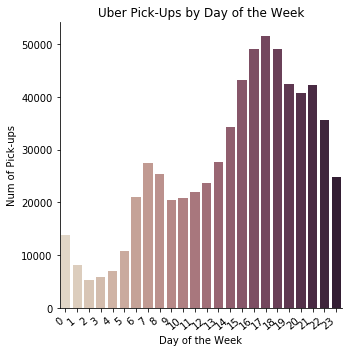

In [77]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="hour", 
               y = 'cnt',
               kind="bar", 
               palette="ch:.25", 
               data=cnts_may
              )
     )

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()